# Ames Housing Prices
Task: Predict final sale price of residential homes in Ames, Iowa


In [1]:
import pandas as pd
import numpy as np
from utils import Compare, histplots

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

import seaborn as sns
sns.set_style("darkgrid")

<Axes: >

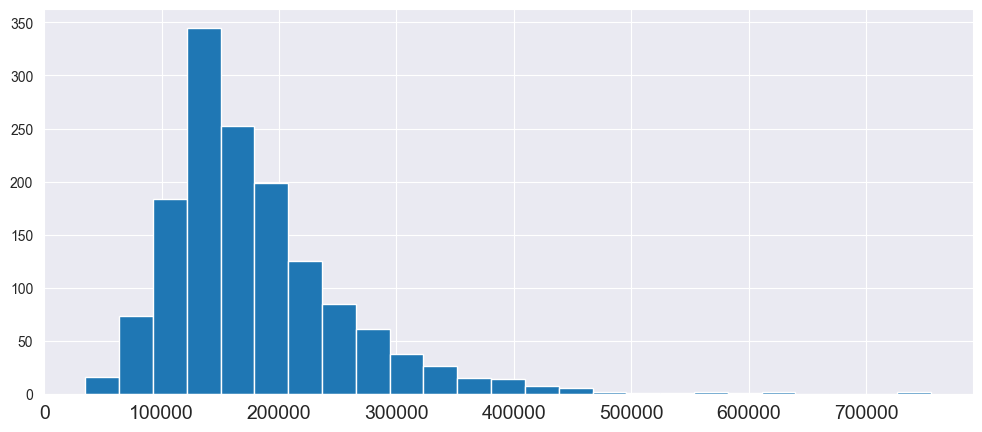

In [2]:
df_import = pd.read_csv("data/train.csv", index_col="Id").reset_index(drop=True)

df = df_import.copy()

df["SalePrice"].hist(bins=25)

<Axes: >

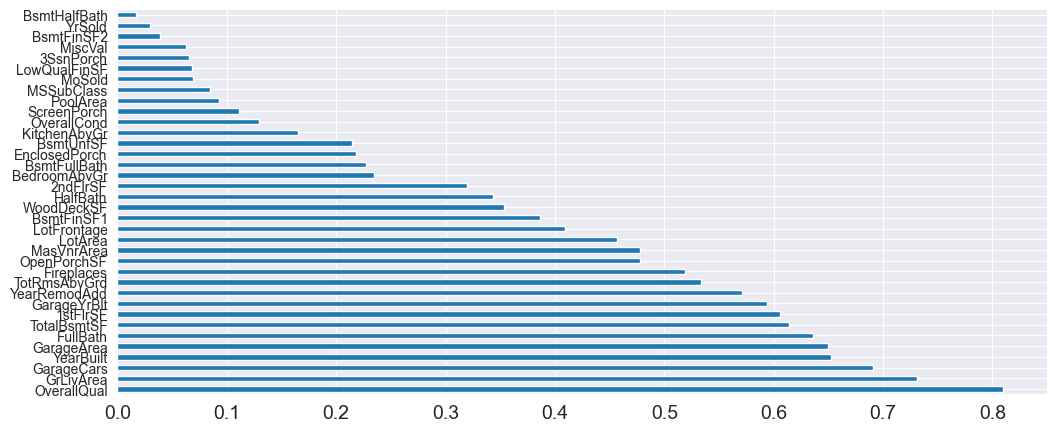

In [3]:
key_drivers = pd.Index(["OverallQual", "GrLivArea", "Neighborhood", "YearBuilt", "YearRemodAdd", "TotalBsmtSF", "GarageArea", "LotArea"])

numeric_cols = df.columns[df.dtypes.apply(pd.api.types.is_numeric_dtype)]

corrs = pd.DataFrame({
    corr_method: df[numeric_cols].corr(method=corr_method)["SalePrice"].drop("SalePrice")
    
    # Take both linear and nonlinear correlation into account
    for corr_method in ["pearson", "spearman"]
})

corrs_ranked = corrs.abs().max(axis=1).sort_values(ascending=False)

corrs_ranked.plot(kind="barh")

In [4]:
# This utility function tracks changes to the shape of a dataframe.
# In this case we want to see how many top-correlated features we added
with Compare(key_drivers.to_frame()) as cm:
    key_drivers = key_drivers.union(
            corrs_ranked[corrs_ranked.ge(0.5)].index
        )
    cm.register(key_drivers.to_frame())

Shape before: (8, 1)
Shape after:  (14, 1)
Added 6 (75.0%) rows



In [5]:
df = df[key_drivers.union({"SalePrice"})].copy()

df["Neighborhood"].nunique()

25

In [6]:
pd.DataFrame({
    "abs": df["Neighborhood"].value_counts(),
    "rel": df["Neighborhood"].value_counts(normalize=True)
}).head()

,abs,rel
Neighborhood,,
NAmes,225,0.154110
CollgCr,150,0.102740
OldTown,113,0.077397
Edwards,100,0.068493
Somerst,86,0.058904


<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

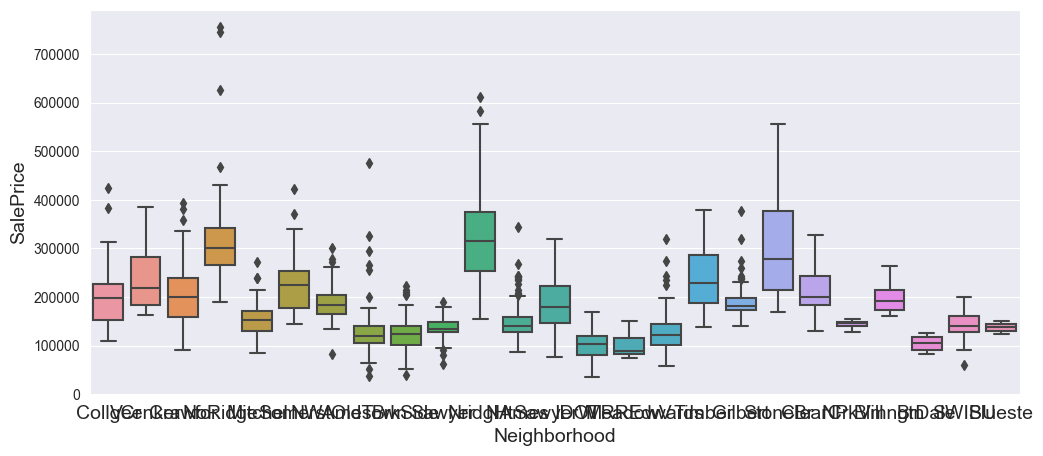

In [7]:
sns.boxplot(data=df, x="Neighborhood", y="SalePrice")


In [8]:
df.describe().apply(round).map(int).drop(["count", "std"]).T.drop("SalePrice")

,mean,min,25%,50%,75%,max
1stFlrSF,1163,334,882,1087,1391,4692
Fireplaces,1,0,0,1,1,3
FullBath,2,0,1,2,2,3
GarageArea,473,0,334,480,576,1418
GarageCars,2,0,1,2,2,4
GarageYrBlt,1979,1900,1961,1980,2002,2010
GrLivArea,1515,334,1130,1464,1777,5642
LotArea,10517,1300,7554,9478,11602,215245
OverallQual,6,1,5,6,7,10
TotRmsAbvGrd,7,2,5,6,7,14


In [9]:
from sklearn.metrics import root_mean_squared_error as RMSE, mean_absolute_error as MAE

from sklearn.model_selection import KFold

N_SPLITS = 10

kfcv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

XyTuple = tuple[pd.DataFrame, pd.Series]

def cv_split_df(train_idx, test_idx, df: pd.DataFrame) -> tuple[XyTuple, XyTuple]:
    
    X_train = df.drop("SalePrice", axis=1).iloc[train_idx]
    y_train = df.iloc[train_idx]["SalePrice"]
    X_test = df.drop("SalePrice", axis=1).iloc[test_idx]
    y_test = df.iloc[test_idx]["SalePrice"]

    return (X_train, y_train), (X_test, y_test)

# Benchmark Model

class GroupbyAggBenchmarkModel:
    """Fit groupby and agg to the data and use these for prediction.

    Param `agg_func_name` will be passed to Pandas `agg` method.
    """

    def __init__(self, groupby_cols: list[str], agg_func_name: str = "mean"):
        self.groupby_cols = groupby_cols
        self.agg_func_name = agg_func_name

    def fit(self, X: pd.DataFrame, y: pd.Series):
        Xy = X.assign(target=y)
        self.group_aggs = Xy.groupby(self.groupby_cols)["target"].agg(self.agg_func_name)
        self.global_agg = y.agg(self.agg_func_name)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        y_pred = pd.merge(
            X,
            self.group_aggs,
            how="left",
            on=self.groupby_cols
        )["target"]
        y_pred = y_pred.fillna(self.global_agg)
        return y_pred
    
bm = GroupbyAggBenchmarkModel(groupby_cols=["Neighborhood"])

rmses = []
maes = []
p95s = []

for train_idx, test_idx in kfcv.split(df.index):
    (X_train, y_train), (X_test, y_test) = cv_split_df(train_idx, test_idx, df)

    bm.fit(X_train, y_train)
    y_pred = bm.predict(X_test)

    k_rmse = RMSE(y_test, y_pred)
    k_mae = MAE(y_test, y_pred)
    
    res = y_pred - y_test
    k_p95 = res.abs().quantile(0.95)


    rmses.append(k_rmse)
    maes.append(k_mae)
    p95s.append(k_p95)

rmses = pd.Series(rmses)
maes = pd.Series(maes)
p95s = pd.Series(p95s)

In [10]:
rmses.agg(['mean', 'min'])

mean    54264.830521
min     49786.920809
dtype: float64

In [11]:
p95s.agg(['mean', 'min'])

mean    151149.907773
min      96628.967273
dtype: float64

In [12]:
# Even though we are not evaluating on a relative metric, it's useful to check, to contextualize our result.
# We are currently about 30% off from the eventual sale price:

print("Relative (%) RMSE:", rmses.mean() / df["SalePrice"].mean())

Relative (%) RMSE: 0.2999362802914976


<Axes: >

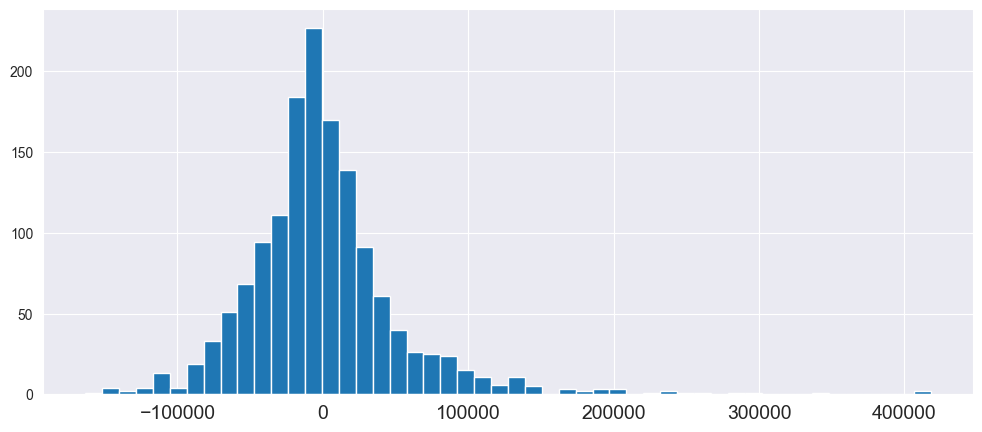

In [13]:
best_mean_rmse = rmses.mean()

best_mean_p95 = p95s.mean()

X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
y_pred = bm.predict(X)

res_benchmark = y - y_pred

res_benchmark.hist(bins=50)

In [14]:
df[key_drivers].head()

,1stFlrSF,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,LotArea,Neighborhood,OverallQual,TotRmsAbvGrd,TotalBsmtSF,YearBuilt,YearRemodAdd
0,856,0,2,548,2,2003.0,1710,8450,CollgCr,7,8,856,2003,2003
1,1262,1,2,460,2,1976.0,1262,9600,Veenker,6,6,1262,1976,1976
2,920,1,2,608,2,2001.0,1786,11250,CollgCr,7,6,920,2001,2002
3,961,1,1,642,3,1998.0,1717,9550,Crawfor,7,7,756,1915,1970
4,1145,1,2,836,3,2000.0,2198,14260,NoRidge,8,9,1145,2000,2000


In [31]:
df["YrSold"] = df_import["YrSold"]

for yr_col_name in ["GarageYrBlt", "YearBuilt", "YearRemodAdd"]:
    df.loc[df[yr_col_name].notnull(), yr_col_name] -= df.loc[df[yr_col_name].notnull(), "YrSold"]

df = df.drop("YrSold", axis=1)

import lightgbm as lgb

model_params = {
    "verbosity": 0,
    "objective": "regression"
}

from sklearn.preprocessing import LabelEncoder

cat_cols = df.columns[df.dtypes.eq("object")]

label_encoders = {}

for cat_col in cat_cols:
    enc = LabelEncoder()
    df[cat_col] = enc.fit_transform(df[cat_col])
    label_encoders[cat_col] = enc

In [32]:
%%time
# Training loop
rmses = []
maes = []
p95s = []
rmses_train = []

for train_idx, test_idx in kfcv.split(df.index):
    (X_train, y_train), (X_test, y_test) = cv_split_df(train_idx, test_idx, df)
    
    Xy_train = lgb.Dataset(X_train, y_train)
    Xy_test = lgb.Dataset(X_test, y_test)
    
    model = lgb.train(model_params,
                      Xy_train,
                      100,
                      valid_sets=[Xy_train, Xy_test],
                      callbacks=[lgb.early_stopping(stopping_rounds=10)])
    
    y_pred = model.predict(X_test)
    
    k_rmse = RMSE(y_test, y_pred)
    k_mae = MAE(y_test, y_pred)
    
    res = y_pred - y_test
    k_p95 = res.abs().quantile(0.95)
    
    rmses.append(k_rmse)
    maes.append(k_mae)
    p95s.append(k_p95)
    
    # bookkeeping of training RMSEs, for later comparison
    y_pred_train = model.predict(X_train)
    rmses_train.append(RMSE(y_train, y_pred_train))

# Convert results to pandas Series
rmses = pd.Series(rmses)
maes = pd.Series(maes)
p95s = pd.Series(p95s)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's l2: 2.62683e+08	valid_1's l2: 1.13471e+09
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's l2: 2.90637e+08	valid_1's l2: 6.46283e+08
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's l2: 6.28112e+08	valid_1's l2: 5.08122e+08
[LightGBM] [Warning] Auto-choosing col-wise

In [33]:
rmses.agg(['mean', 'min'])

mean    29073.449729
min     21624.214767
dtype: float64

In [34]:
p95s.agg(['mean', 'min'])

mean    54170.362991
min     44721.967178
dtype: float64

C:\Users\zhura_0pw5sm1\AppData\Roaming\Python\Python313\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\zhura_0pw5sm1\AppData\Roaming\Python\Python313\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


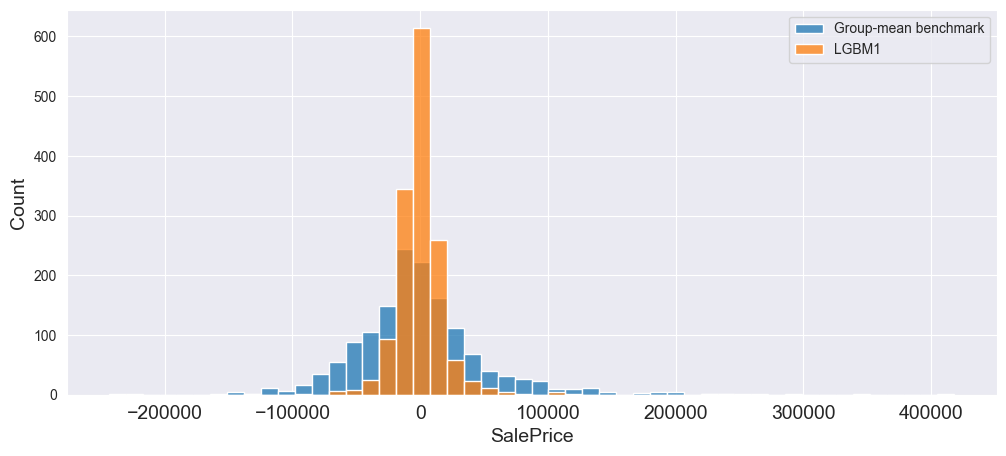

In [35]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
y_pred = model.predict(X)

res = y - y_pred

# We'll plot both histograms with the same bins, for a clear visual comparison.
# (Throwing an internal error, but we don't have INFs in our dataset)

histplots(
    (res_benchmark, "Group-mean benchmark"),
    (res, "LGBM1"),
    bins=50
)

In [36]:
res.abs().describe(percentiles=[0.25, 0.50, 0.75, 0.95])

count      1460.000000
mean      12473.157081
std       17732.931815
min          10.030931
25%        3925.086997
50%        8087.785580
75%       14988.598773
95%       36707.188756
max      243798.600731
Name: SalePrice, dtype: float64

In [37]:
print("Relative (%) RMSE:", rmses.mean() / df["SalePrice"].mean())
print("Improvement (%) on best (mean over K folds) RMSE:", (rmses.mean() / best_mean_rmse) - 1)
print("Improvement (%) on best (mean over K folds) 95th perc of abs errors:", (p95s.mean() / best_mean_p95) - 1)

Relative (%) RMSE: 0.16069675853274834
Improvement (%) on best (mean over K folds) RMSE: -0.464230341269243
Improvement (%) on best (mean over K folds) 95th perc of abs errors: -0.6416116702333245


<Axes: >

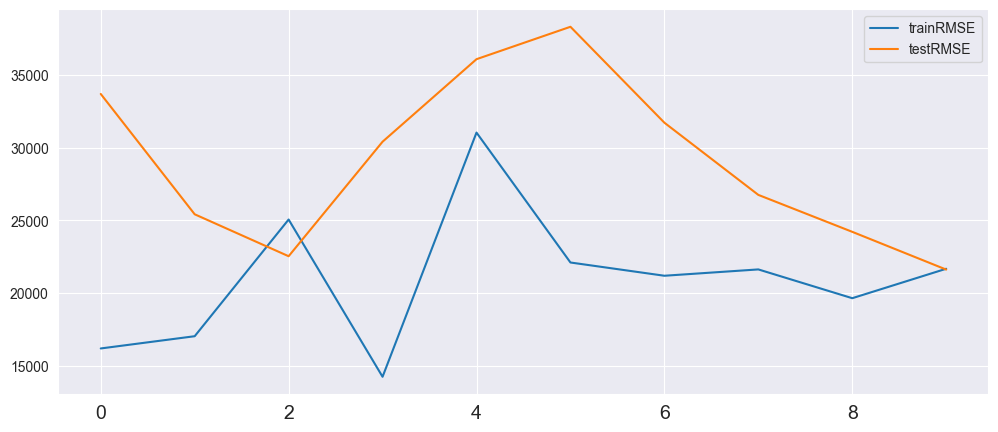

In [38]:
pd.DataFrame({
    "trainRMSE": rmses_train,
    "testRMSE": rmses
}).plot()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

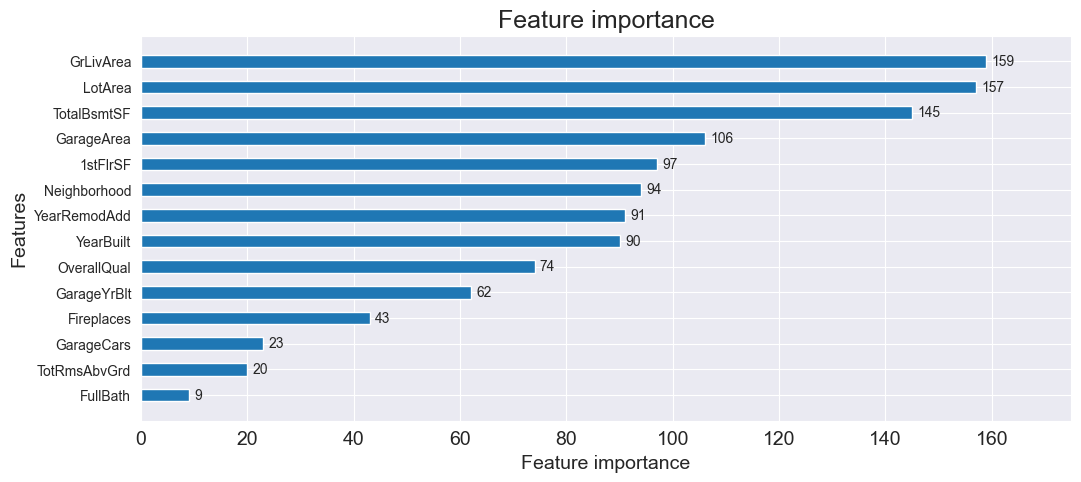

In [39]:
lgb.plot_importance(model, height=0.5, importance_type="auto")

In [40]:
import shap

In [41]:
%%time
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent", feature_names=df.columns)

CPU times: total: 15.6 ms
Wall time: 17.8 ms


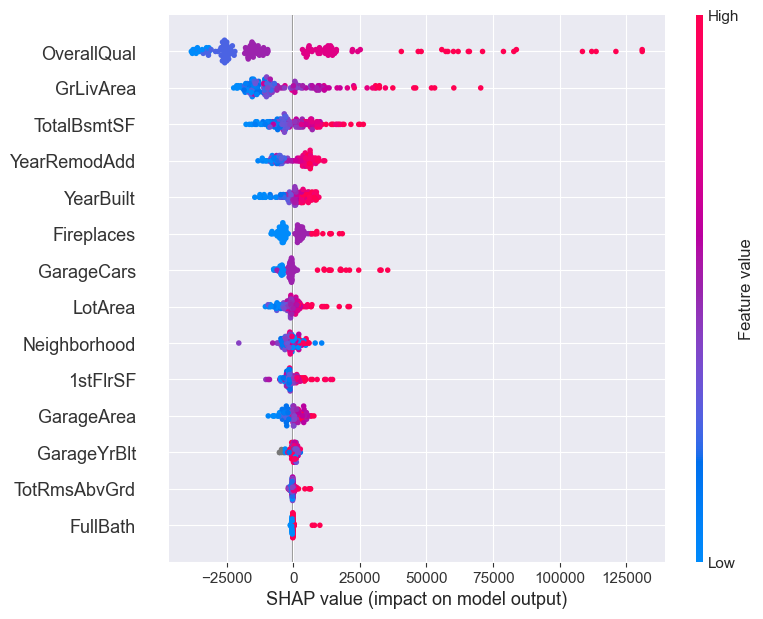

In [42]:
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=15)

In [46]:
model.save_model("lgbm__15feat.bin")

In [56]:
import json

# First check if Neighborhood is being detected as categorical
print("Neighborhood dtype:", df["Neighborhood"].dtype)

# Force Neighborhood to be treated as categorical if needed
df["Neighborhood"] = df["Neighborhood"].astype("object")

# Now create encoders
cat_cols = df.columns[df.dtypes.eq("object")]
label_encoders = {}

for cat_col in cat_cols:
    enc = LabelEncoder()
    df[cat_col] = enc.fit_transform(df[cat_col])
    label_encoders[cat_col] = enc
    
# Create encoder for Neighborhood specifically
neighborhood_encoder = LabelEncoder()
neighborhood_encoder.fit(df_import["Neighborhood"])  # Fit on original values

# Save encoding
with open("neighborhood_encoding.json", "w") as f:
    strs = pd.Series(df_import["Neighborhood"].unique())
    ints = neighborhood_encoder.transform(strs).tolist()
    encoding = dict(zip(strs, ints))
    json.dump(encoding, f)

Neighborhood dtype: int32
